# Проект для «Викишоп» с BERT

**Заказчик** — Интернет-магазин «Викишоп».

**Цель работы:** создание системы для определения эмоциональной оценки коментариев.

**Дано:** Данные представленны таблицей с разметкой о токсичности правок. Столбец `'text'` в нём содержит текст комментария, а `'toxic'` — целевой признак.

**Этапы выполнения проекта:**
1. Загрузка и подготовка данных.
2. Обучение моделей.
3. Написание выводов.

## Загрузка библиотек и данных

In [2]:
# Настройка широкоформатного режима Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import requests
import optuna
import os
import re
import nltk
import xgboost as xgb
import torch
import transformers

from io import StringIO
from scipy import stats as st
from tqdm import notebook
from joblib import Parallel, delayed
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, make_scorer, f1_score, precision_recall_curve, average_precision_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from optuna import TrialPruned
from optuna.pruners import ThresholdPruner, SuccessiveHalvingPruner
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from catboost import CatBoostClassifier

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

STOP_WORDS = set(stopwords.words('english'))
RANDOM_STATE = 73

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Список самописных функций
def hist_boxplot_combination_(values: np.array, title: str, xlabel: str, ylabel: str) -> plt:
    '''
    Графики гистограммы и размаха с совмещённой осью абсцисс
    values: np.array - массив данных
    title: str - название графика
    xlabel: str - название оси абсцисс
    ylabel: str - название оси ординат
    return plt - график
    '''
    _ = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 

    ax0 = plt.subplot(gs[0]) # График distplot
    sns.histplot(values, ax=ax0, bins=int(np.std(values)))
    ax1 = plt.subplot(gs[1]) # Горизонтальный boxplot
    sns.boxplot(x=values, ax=ax1, orient='h')

    ax0.set_xlim([np.min(values), np.max(values)])
    ax1.set_xlim([np.min(values), np.max(values)])

    ax0.set_title(title)
    ax0.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)

    return plt.show()

def trimmed_std_(values: np.array, percentile: float) -> float:
    '''
    Величина стандартного отклонения на основе усечённой средней
    values: np.array - массив данных
    percentile: float - процент отсечения данных
    return float - значение усечённой дисперсии
    '''
    values.sort()
    percentile = percentile / 2
    low = int(percentile * len(values))
    high = int((1 - percentile) * len(values))

    return values[low:high].std(ddof=0)

In [5]:
pth1 = './data/toxic_comments.csv'
pth2 = None

if os.path.exists(pth1):
    df_raw = pd.read_csv(pth1, index_col=[0])
elif requests.get(pth2).status_code == 200:
    df_raw = pd.read_csv(pth2, index_col=[0])
else:
    print('Что-то не так!')

display(df_raw.head())
df_raw.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
# Основные статистики категориальных признаков
display(df_raw.astype('object').describe(include = ['object']).transpose())
print(df_raw.toxic.value_counts())

,count,unique,top,freq
text,159292,159292,How does the offspring of my grandfather and a...,1
toxic,159292,2,0,143106


0    143106
1     16186
Name: toxic, dtype: int64


Отмещен дисбаланс классов целевого признака, доля негативных сообщений 11,3% (1/8,8 долям).

### Вывод
<p style="text-indent: 40px;">
Исследуемые данные состоят из одной таблицы, которая включает два столбца с собственно самим коротким сообщением (в количестве 159292 шт) и его эмоциональной оценкой. Все текстовые сообщения имеют уникальный состав, а эмоциональная оценка имеет бинарную природу 0 или 1. Собственно эмоциональная оценка имеет неравномерное распределение классов (1 - 11,3%, 0 - 88,7%), в соотношении 1 негативный класс к 8,8 позитивным классам.

___

## Предварительная обработка данных

In [7]:
# Приведение к регулярным выражениям, нижнему регистру и удаление стопслов
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text).split()
    filtered_words = [word for word in text if word.casefold() not in STOP_WORDS]
    return ' '.join(filtered_words).lower()

df_raw['clear'] = [clear_text(df_raw.text.values[i]) for i in notebook.tqdm(range(len(df_raw)))]
df_raw.clear.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

0    explanation edits made username hardcore metal...
1    aww matches background colour seemingly stuck ...
2    hey man really trying edit war guy constantly ...
3    make real suggestions improvement wondered sec...
4                        sir hero chance remember page
Name: clear, dtype: object

In [8]:
# Преобразование тегов из treebank в теги WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

# Лематизация текста
def lemmatize_pos(text): 
    words = nltk.word_tokenize(text) # Разбивание предложения на слова
    pos_tags = nltk.pos_tag(words) # Получение pos тегов для слов
    wordnet_tags = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos_tags] # Преобразование pos тегов в теги WordNet
    lemmas = [WordNetLemmatizer().lemmatize(word, tag) if tag else word for (word, tag) in wordnet_tags] # Лемматизация слов
    return ' '.join(lemmas)

df_raw['clear_lem'] = [lemmatize_pos(df_raw.clear.values[i]) for i in notebook.tqdm(range(len(df_raw)))]
df_raw['clear_lem'].head()

  0%|          | 0/159292 [00:00<?, ?it/s]

0    explanation edits make username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really try edit war guy constantly rem...
3    make real suggestion improvement wonder sectio...
4                        sir hero chance remember page
Name: clear_lem, dtype: object

In [9]:
# Поиск и удаление дубликатов
print('Количество дубликатов в отформатированном списке сообщений', df_raw.clear_lem.duplicated().sum())
df_raw.drop_duplicates(subset=['clear_lem'], inplace=True)

# Поиск и удаление твитов, с нулевым количеством слов
df_raw['num_words'] = [len(i.split()) for i in df_raw.clear_lem.values]
print('Количество наблюдений с нулевым количеством слов:', df_raw[df_raw.num_words == 0].shape[0])
df_raw = df_raw[df_raw.num_words >= 1]
df_raw.reset_index(drop=True, inplace=True)

df_raw.shape

Количество дубликатов в отформатированном списке сообщений 1932
Количество наблюдений с нулевым количеством слов: 1


(157359, 5)

### Вывод
<p style="text-indent: 40px;">
После выполнения очистки текста от посторонних символов и удаление стоп слов, медианная длита твитов сократилась на 50% (с 36 до 18 слов). Лемматизация и очистка дубликатов сократило исследуеммый набор данных на 1932 наблюдений, которые, вероятней всего, будут нести схожую смысловую нагрузку. Так же удалены наблюдения с нулевым количеством слов.

___

## Исследовательский анализ

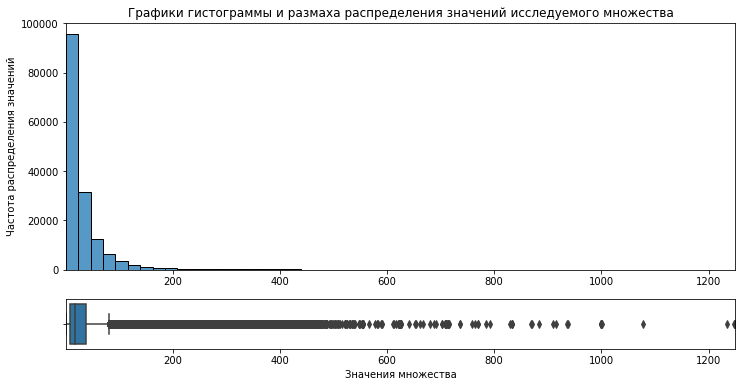

,count,mean,std,min,1%,25%,50%,75%,99%,max
num_words,157359.0,34.87,54.19,1.0,2.0,9.0,18.0,38.0,303.0,1250.0


Среднее усеченное: 23.6
Стандартное отклонение на основе усеченной средней: 23.6


In [10]:
hist_boxplot_combination_(
    values=df_raw.num_words.values,
    title='Графики гистограммы и размаха распределения значений исследуемого множества',
    xlabel='Значения множества',
    ylabel='Частота распределения значений',
)
display(pd.DataFrame(df_raw.num_words.describe(percentiles=[.01,.25,.5,.75,.99])).round(2).transpose())
print('Среднее усеченное:', st.trim_mean(df_raw.num_words, 0.1).round(1))
print('Стандартное отклонение на основе усеченной средней:', trimmed_std_(df_raw.num_words.values, 0.1).round(1))

<p style="text-indent: 40px;">
Оценка центрального положения выборки показывает, что среднее значением 34,9 сильно больше медианного 18. Снизив влияние выбросов, рассчитав среднее усечённое значение (отсечение 10%), получаем смещение рассчитанного значения среднего сильно ближе к медианному. Оценка вариабельности выборки показывает сильное отличие размаха диапазона значений хвостов выборки 25%-min=8 и max-75%=1212 что свидетельствует о сильной правосторонней асимметрии наблюдаемого распределения. Размах выборки в 43 раза больше интерквантильного размаха, что говорит о наличии значительных выбросов, что также подтверждает сильное превышение стандартного отклонения над средним значением, и отличие в двое стандартного отклонения от стандартного отклонения по усечённой средней. Из выше сказанного очевидно, что корректировка количества наблюдаемых выбросов поможет улучшить результаты работы ML.

In [11]:
# Исследование частот распределения слов в данных
frequency_text = df_raw.clear_lem.str.split().explode().value_counts()

print('Количество слов:', frequency_text.sum())
print('Количество уникальных слов:', frequency_text.count())
print('Количество уникальных слов, встречающихся 1 раз:', frequency_text[frequency_text < 2].count())

Количество слов: 5487345
Количество уникальных слов: 157685
Количество уникальных слов, встречающихся 1 раз: 82418


In [12]:
# Удаление слов из твитов, встречающихся один раз на весь набор данных
TUNE_TEXT = False
if TUNE_TEXT:
    filtered_text = np.ascontiguousarray(frequency_text[frequency_text < 2].sort_index().index)

    def clear_text_clear(text):
        text = text.split()
        filtered_words = [word for word in text if word not in filtered_text]
        return ' '.join(filtered_words)

    df_raw['clear_lem'] = Parallel(n_jobs=-1)(delayed(clear_text_clear)(df_raw.clear_lem[i]) for i in notebook.tqdm(range(len(df_raw))))

    df_raw['clear_lem'].to_csv('clear_lem_clear.csv', index=False)
else:
    file_url = 'https://drive.google.com/file/d/1T5NelQt29JwMKecH4egXJa0a7x6Xp0ar/view?usp=sharing'
    file_id = file_url.split('/')[-2] # Извлекаем идентификатор файла из URL-адреса

    # Формируем URL-адрес для загрузки файла
    download_url = 'https://drive.google.com/uc?export=download&id=' + file_id

    df_raw['clear_lem'] = pd.read_csv(StringIO(requests.get(download_url).text)) # Размер файла 36Mb
    df_raw['num_words'] = [len(str(i).split()) for i in df_raw.clear_lem.values]

    display(df_raw['clear_lem'].head())

    print('Количество дубликатов в отформатированном списке сообщений', df_raw.clear_lem.duplicated().sum())
    df_raw.drop_duplicates(subset=['clear_lem'], inplace=True)
    df_raw.dropna(inplace=True)
    df_raw.reset_index(drop=True, inplace=True)
    
    print('Количество слов:', df_raw.clear_lem.str.split().explode().count())
    print('Количество уникальных слов:', df_raw.clear_lem.str.split().explode().nunique())

0    explanation edits make username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really try edit war guy constantly rem...
3    make real suggestion improvement wonder sectio...
4                        sir hero chance remember page
Name: clear_lem, dtype: object

Количество дубликатов в отформатированном списке сообщений 480
Количество слов: 5383749
Количество уникальных слов: 75267


<p style="text-indent: 40px;">
В исследуемом наборе текстов обнаружено чуть менее 5,5 мил. слов и 158К из них уникальны. Исследуя частоту встречаемости слов в тексте, более 81К имеют частоту равную одному и явно не годятся для классификации, поскольку вероятность встречи каждого из их крайне мала (1/5,5 мил.). Очистка подобных слов сокращает признаковое пространство на 51,3% при этом общее количество слов снижается на 1,9%, что не должно сказаться негативно на качестве обучения ML и должно повысить его эффективность.

### Вывод
<p style="text-indent: 40px;">
Оценка центрального положения выборки показывает, что среднее значением 68,3 сильно больше медианного 36. Снизив влияние выбросов, рассчитав среднее усечённое значение, получаем смещение рассчитанного значения среднего заметно ближе к медианному. Оценка вариабельности выборки показывает сильное отличие размаха диапазона значений хвостов выборки 25%-min=17 и max-75%=1327 что свидетельствует о правосторонней асимметрии наблюдаемого распределения. Размах выборки в 23,8 раза больше интерквантильного размаха, что говорит о наличии значительных выбросов, что также подтверждает сильное превышение стандартного отклонения над средним значением, и отличие в двое стандартного отклонения от стандартного отклонения по усечённой средней. Из выше сказанного очевидно, что корректировка количества наблюдаемых выбросов поможет улучшить результаты работы ML.
<p style="text-indent: 40px;">
В исследуемом наборе текстов обнаружено чуть менее 5,5 мил. слов и 158К из них уникальны. Исследуя частоту встречаемости слов в тексте, более 81К имеют частоту равную одному и явно не годятся для классификации, поскольку вероятность встречи каждого из их крайне мала (1/5,5 мил.). Очистка подобных слов сокращает признаковое пространство на 51,3% при этом общее количество слов снижается на 1,9%, что не должно сказаться негативно на качестве обучения ML и должно повысить его эффективность.

___

## Обучение моделей

In [13]:
# Список зипланированных к иследованию методов
class_models_type = [
    ('mlr', LogisticRegression(random_state=RANDOM_STATE, max_iter=500, class_weight='balanced')),
    ('mdtc', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')),
    ('mcbc', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, auto_class_weights='Balanced', task_type='GPU')),
    ('mxgb', xgb.XGBClassifier(random_state=RANDOM_STATE, verbosity=0, scale_pos_weight=9)),
]
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
}

### Обучение моделей с использованием bag-of-words

In [14]:
# Поиск оптимального значения отсечения выбрасов для bag-of-words
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        estimation = trial.suggest_int('estimation', 80, 150)

        X_train, X_test, Y_train, Y_test = train_test_split(
            df_raw[df_raw.num_words < estimation].clear_lem.values, 
            df_raw[df_raw.num_words < estimation].toxic.values, 
            stratify=df_raw[df_raw.num_words < estimation].toxic.values,
            test_size=0.2,
            random_state=RANDOM_STATE,
            shuffle=True
        )
        try:
            pipeline = Pipeline([
                ('count_vect', CountVectorizer()), 
                ('mlr', class_models_type[0][1]),
            ])
            scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=make_scorer(f1_score), cv=4)

            return np.mean(scores['test_score'])
        except:
            raise optuna.TrialPruned()
        
    study = optuna.create_study(direction='maximize', 
                                sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner()
                                )
    study.optimize(objective, n_trials=500, timeout=None, n_jobs=-1)
else:
    print('Оптимальное значение отсечения выбрасов: 87')

Оптимальное значение отсечения выбрасов: 87


In [15]:
# Подбор оптимальной безлайновой модели для bag-of-words
X_train, X_test, Y_train, Y_test = train_test_split(
    df_raw[df_raw.num_words < 87].clear_lem.values, 
    df_raw[df_raw.num_words < 87].toxic.values, 
    stratify=df_raw[df_raw.num_words < 87].toxic.values,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

TUNE_MODELS = False
if TUNE_MODELS:
    for name, model in class_models_type:
        pipeline = Pipeline([
            ('count_vect', CountVectorizer()), 
            ('model', model)
        ])
        scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=4)

        print(f'{name}: accuracy:', np.round(np.mean(scores['test_accuracy']),3))
        print(f'{name}: f1:', np.round(np.mean(scores['test_f1']),3))
        print(f'{name}: recall:', np.round(np.mean(scores['test_recall']),3))
        print(f'{name}: precision:', np.round(np.mean(scores['test_precision']),3))
        print(f'{name}: fit_time:', np.round(np.mean(scores['fit_time'])/60,3))

(115111,) (28778,) (115111,) (28778,)


| Модели классификации       | accuracy |   f1   | recall | precision | fit_time |
| -------------------------- | -------- | ------ | ------ | --------- | -------- |
| LogisticRegression         | 0.947    | 0.766  | 0.830  | 0.710     | 0.102    |
| DecisionTreeClassifier     | 0.913    | 0.638  | 0.730  | 0.567     | 0.604    |
| CatBoostClassifier         | 0.944    | 0.748  | 0.799  | 0.704     | 1.077    |
| XGBClassifier              | 0.945    | 0.750  | 0.790  | 0.713     | 0.167    |

Лучшие результаты для bag-of-words показывает LogisticRegression со значением f1=0.766. Максимальное количество слов в твитах определено на уровне 87 шт.

### Обучение моделей с использованием TF-IDF

In [16]:
# Поиск оптимального значения отсечения выбрасов на TF-IDF
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        estimation = trial.suggest_int('estimation', 50, 1250)

        X_train, X_test, Y_train, Y_test = train_test_split(
            df_raw[df_raw.num_words < estimation].clear_lem.values, 
            df_raw[df_raw.num_words < estimation].toxic.values, 
            stratify=df_raw[df_raw.num_words < estimation].toxic,
            test_size=0.2,
            random_state=RANDOM_STATE,
            shuffle=True
        )
        try:
            pipeline = Pipeline([
                ('count_vect', TfidfVectorizer()), 
                ('mcbc', class_models_type[0][1])
            ])
            scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=make_scorer(f1_score), cv=3)

            return np.mean(scores['test_score'])
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='maximize', 
                                sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner()
                                )
    study.optimize(objective, n_trials=500, timeout=None, n_jobs=-1)
else:
    print('Оптимальное значение отсечения выбрасов: 90')

Оптимальное значение отсечения выбрасов: 90


In [17]:
# Подбор оптимальной безлайновой модели для TF-IDF
X_train, X_test, Y_train, Y_test = train_test_split(
    df_raw[df_raw.num_words < 90].clear_lem.values,
    df_raw[df_raw.num_words < 90].toxic.values, 
    stratify=df_raw[df_raw.num_words < 90].toxic.values,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

TUNE_MODELS = False
if TUNE_MODELS:
    for name, model in class_models_type:
        pipeline = Pipeline([
            ('count_vect', TfidfVectorizer()), 
            ('model', model)
        ])
        scores = cross_validate(estimator=pipeline, X=X_train, y=Y_train, scoring=scoring, cv=4)

        print(f'{name}: accuracy:', np.round(np.mean(scores['test_accuracy']),3))
        print(f'{name}: f1:', np.round(np.mean(scores['test_f1']),3))
        print(f'{name}: recall:', np.round(np.mean(scores['test_recall']),3))
        print(f'{name}: precision:', np.round(np.mean(scores['test_precision']),3))
        print(f'{name}: fit_time:', np.round(np.mean(scores['fit_time'])/60,3))

(115688,) (28923,) (115688,) (28923,)


| Модели классификации       | accuracy |   f1   | recall | precision | fit_time |
| -------------------------- | -------- | ------ | ------ | --------- | -------- |
| LogisticRegression         | 0.943    | 0.756  | 0.846  | 0.683     | 0.053    |
| DecisionTreeClassifier     | 0.911    | 0.634  | 0.735  | 0.558     | 0.705    |
| CatBoostClassifier         | 0.944    | 0.750  | 0.802  | 0.705     | 2.006    |
| XGBClassifier              | 0.944    | 0.745  | 0.785  | 0.709     | 0.742    |

Лучшие результаты для TF-IDF показывает LogisticRegression со значением f1=0.756. Максимальное количество слов в твитах определено на уровне 90 шт.

### Обучение моделей с использованием Bert

In [18]:
# Список зипланированных к иследованию методов
class_models_type = [
    ('mlr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')),
    ('mcbc', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, auto_class_weights='Balanced')),
    ('mxgb', xgb.XGBClassifier(random_state=RANDOM_STATE, verbosity=0, scale_pos_weight=9)),
]
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
}

In [19]:
pth1 = './data/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df_bert = pd.read_csv(pth1, index_col=[0])
elif requests.get(pth2).status_code == 200:
    df_bert = pd.read_csv(pth2, index_col=[0])
else:
    print('Что-то не так!')

display(df_bert.head())

#df_bert = df_bert.sample(n=8007, random_state=73)

# Приведение к регулярным выражениям, нижнему регистру
def clear_text(text):
    return ' '.join(re.sub(r'[^a-zA-Z]', ' ', text).split()).lower()

corpus = df_bert['text'].values

df_bert['clear'] = [clear_text(corpus[i]) for i in notebook.tqdm(range(len(corpus)))]
display(df_bert.clear.head())

# Поиск и удаление дубликатов
print('Количество дубликатов в отформатированном списке сообщений', df_bert.clear.duplicated().sum())
df_bert.drop_duplicates(subset=['clear'], inplace=True)

# Поиск и удаление твитов, с нулевым количеством слов
df_bert['num_words'] = [len(i.split()) for i in df_bert.clear.values]
print('Количество наблюдений с нулевым количеством слов:', df_bert[df_bert.num_words == 0].shape[0])
df_bert = df_bert[df_bert.num_words >= 1]

df_bert.shape

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


  0%|          | 0/159292 [00:00<?, ?it/s]

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: clear, dtype: object

Количество дубликатов в отформатированном списке сообщений 1323
Количество наблюдений с нулевым количеством слов: 1


(157968, 4)

In [20]:
# Получение векторного представления текста
TUNE_MODELS = False
if TUNE_MODELS:

    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')
    model = AutoModelForSequenceClassification.from_pretrained('unitary/toxic-bert')

    # Токенизация списка твитов
    encoded_tweets = tokenizer.batch_encode_plus(
        df_raw.clear.to_list(),
        add_special_tokens=True, # Добавление специальных токенов начала и разделитель к входным данным перед кодированием
        padding=True, # Добавление заполнения до одинаковой длины
        truncation=True, # Обрезка последовательностей, если они превышают максимальную длину
        max_length=512, # Установка максимальной длины токена
        return_tensors='pt' # Возврат тензоров PyTorch
    )
    print(encoded_tweets['input_ids'].shape, encoded_tweets['attention_mask'].shape)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    batch_size = 144
    embeddings = []
    for i in notebook.tqdm(range(encoded_tweets['input_ids'].shape[0] // batch_size)):
        batch = torch.LongTensor(encoded_tweets['input_ids'][batch_size*i:batch_size*(i+1)]).to(device) 
        attention_mask_batch = torch.LongTensor(encoded_tweets['attention_mask'][batch_size*i:batch_size*(i+1)]).to(device) 
            
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0].cpu().numpy())

    features_bert = pd.DataFrame(np.concatenate(embeddings))
    #features_bert.to_csv('toxic-bert.csv', index=False)
else:
    file_url = 'https://drive.google.com/file/d/1ZmRGlMuB6Pe3m1HKUnxYF1tUIC6LAub2/view?usp=sharing'
    file_id = file_url.split('/')[-2] # Извлекаем идентификатор файла из URL-адреса

    # Формируем URL-адрес для загрузки файла
    download_url = 'https://drive.google.com/uc?export=download&id=' + file_id

    features_bert = pd.read_csv(StringIO(requests.get(download_url).text))

    display(features_bert.head())

,0,1,2,3,4,5
0,-7.108549,-9.158273,-8.603210,-9.150956,-8.636945,-8.910042
1,-7.355633,-9.049333,-8.620355,-9.012585,-8.639869,-8.905448
2,-6.987301,-9.166099,-8.631073,-9.105227,-8.616288,-8.878115
3,-7.549667,-8.915141,-8.568934,-8.902932,-8.626454,-8.833325
4,-6.987345,-9.119648,-8.705936,-8.909798,-8.595430,-8.831935


In [21]:
# Подбор оптимальной безлайновой модели для Bert
X_train, X_test, Y_train, Y_test = train_test_split(
    features_bert.values, 
    df_bert.toxic.values, 
    stratify=df_bert.toxic.values,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

TUNE_MODELS = False
if TUNE_MODELS:
    for name, model in class_models_type:
        
        scores = cross_validate(estimator=model, X=X_train, y=Y_train, scoring=scoring, cv=4)

        print(f'{name}: accuracy:', np.round(np.mean(scores['test_accuracy']),3))
        print(f'{name}: f1:', np.round(np.mean(scores['test_f1']),3))
        print(f'{name}: recall:', np.round(np.mean(scores['test_recall']),3))
        print(f'{name}: precision:', np.round(np.mean(scores['test_precision']),3))
        print(f'{name}: fit_time:', np.round(np.mean(scores['fit_time'])/60,3))

(126374, 6) (31594, 6) (126374,) (31594,)


Результаты тестирования `'bert-base-uncased'` на обработанных данных

| Модели классификации       | accuracy |   f1   | recall | precision | fit_time |
| -------------------------- | -------- | ------ | ------ | --------- | -------- |
| LogisticRegression         | 0.903    | 0.649  | 0.886  | 0.512     | 0.638    |
| CatBoostClassifier         | 0.928    | 0.691  | 0.795  | 0.612     | 2.656    |
| XGBClassifier              | 0.932    | 0.684  | 0.722  | 0.651     | 0.614    |

Результаты тестирования `'toxic-bert'` на обработанных данных

| Модели классификации       | accuracy |   f1   | recall | precision | fit_time |
| -------------------------- | -------- | ------ | ------ | --------- | -------- |
| LogisticRegression         | 0.980    | 0.909  | 0.985  | 0.843     | 0.007    |
| CatBoostClassifier         | 0.983    | 0.922  | 0.976  | 0.875     | 0.249    |
| XGBClassifier              | 0.984    | 0.925  | 0.973  | 0.882     | 0.007    |

In [22]:
# Подбор оптимальных гиперпараметров для XGBClassifier
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        model = xgb.XGBClassifier(
            random_state=RANDOM_STATE,
            #tree_method='gpu_hist', predictor='gpu_predictor',
            verbosity=0,
            n_estimators=trial.suggest_int('n_estimators', 10, 5000),
            learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.1),
            max_depth=trial.suggest_int('max_depth', 1, 10),
            booster=trial.suggest_categorical('booster', ['gbtree','gblinear']),
            subsample=trial.suggest_float('subsample', 0.1, 1),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.1, 1),
            gamma=trial.suggest_float('gamma', 0, 10),
            reg_alpha=trial.suggest_float('reg_alpha', 0, 10),
            reg_lambda=trial.suggest_float('reg_lambda', 0, 10),
            eval_metric=trial.suggest_categorical('eval_metric', ['error','logloss','auc']),
            objective=trial.suggest_categorical('objective', ['binary:logistic']),
            scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, 10),
            use_label_encoder=False
        )
        scores = cross_validate(estimator=model, X=X_train, y=Y_train, scoring=make_scorer(f1_score), cv=4)

        return np.mean(scores['test_score'])

    study = optuna.create_study(direction='maximize', 
                                sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner()
                                )
    study.optimize(objective, n_trials=1, timeout=None, n_jobs=-1)
else:
    print('''
Количество завершенных испытаний: 500
Лучшее испытание завершено на итерации: 315
Лучшее значение целевой метрики: 0.9459321284643296
''')
    mxgb = xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        #tree_method='gpu_hist', predictor='gpu_predictor',
        objective='binary:logistic',
        eval_metric='error',
        verbosity=0,
        n_estimators=1763,
        learning_rate=0.08702457495007318,
        max_depth=2,
        booster='gbtree',
        subsample=0.8397164317218464,
        colsample_bytree=0.4803252803261486,
        gamma=1.9961007893817477,
        reg_alpha=2.333615006921788,
        reg_lambda=5.371185189500556,
        scale_pos_weight=1.3338561366113044,
        use_label_encoder=False
    )
    scores = cross_validate(estimator=mxgb, X=X_train, y=Y_train, scoring=scoring, cv=4)

    print('Значение accuracy:', np.round(np.mean(scores['test_accuracy']),3))
    print('Значение f1:', np.round(np.mean(scores['test_f1']),3))
    print('Значение recall:', np.round(np.mean(scores['test_recall']),3))
    print('Значение precision:', np.round(np.mean(scores['test_precision']),3))


Количество завершенных испытаний: 500
Лучшее испытание завершено на итерации: 315
Лучшее значение целевой метрики: 0.9459321284643296

Значение accuracy: 0.989
Значение f1: 0.944
Значение recall: 0.95
Значение precision: 0.938


В ходе исследования возможностей нейросети Bert были испробованны следующие варианты предобученных моделей на 5% выборке:
- `bert-base-uncased`
- `bert-large-cased`
- `DeepPavlov/bert-base-cased-conversational`
- `unitary/toxic-bert`

Лучшие результаты продемонстрировала модель `unitary/toxic-bert` на модели XGBClassifier (f1: 0.925). В ходе подбора гиперпараметров целеваня метрика была улучшена до f1: 0.946, немного снизив полноту с 0.973 до 0.954, и заметно повысив точность с 0.882 до 0.938.

### Вывод

Лучшие результаты для bag-of-words показывает LogisticRegression со значением f1=0.766. Максимальное количество слов в твитах определено на уровне 87 слов.

| Модели классификации       | accuracy |   f1   | recall | precision | fit_time |
| -------------------------- | -------- | ------ | ------ | --------- | -------- |
| LogisticRegression         | 0.947    | 0.766  | 0.830  | 0.710     | 0.102    |

Лучшие результаты для TF-IDF показывает LogisticRegression со значением f1=0.756. Максимальное количество слов в твитах определено на уровне 90 слов.

| Модели классификации       | accuracy |   f1   | recall | precision | fit_time |
| -------------------------- | -------- | ------ | ------ | --------- | -------- |
| LogisticRegression         | 0.943    | 0.756  | 0.846  | 0.683     | 0.053    |

Лучшие результаты для предобученной `unitary/toxic-bert` показывает XGBClassifier f1: 0.946

| Модели классификации       | accuracy |   f1   | recall | precision | fit_time |
| -------------------------- | -------- | ------ | ------ | --------- | -------- |
| XGBClassifier              | 0.984    | 0.925  | 0.973  | 0.882     | 0.007    |

По результатом безлайнового тестирования, лучшие результаты показала нейросетевая модель `unitary/toxic-bert` на модели XGBClassifier. Подбор гиперпараметров улучшил значение целевой метрики до f1: 0.946, немного снизив полноту с 0.973 до 0.954, и заметно повысив точность с 0.882 до 0.938.
___

## Тестирование выбранного решения

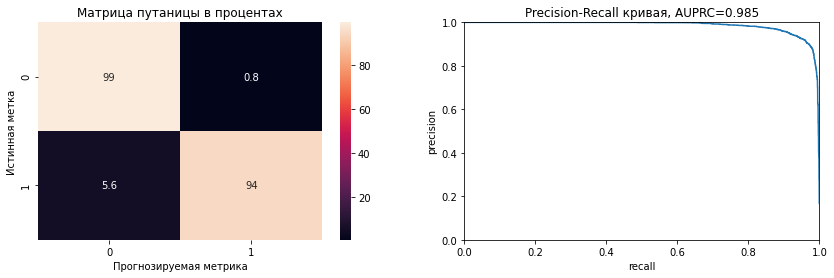

Значение f1: 0.936
Значение recall: 0.944
Значение precision: 0.928
Значение AUPRC: 0.985

Абсолютные значения матрицы путаницы


,pred_neg,pred_pos
targ_neg,28149,235
targ_pos,179,3031


In [23]:
mxgb = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    #tree_method='gpu_hist', predictor='gpu_predictor',
    objective='binary:logistic',
    eval_metric='error',
    verbosity=0,
    n_estimators=1763,
    learning_rate=0.08702457495007318,
    max_depth=2,
    booster='gbtree',
    subsample=0.8397164317218464,
    colsample_bytree=0.4803252803261486,
    gamma=1.9961007893817477,
    reg_alpha=2.333615006921788,
    reg_lambda=5.371185189500556,
    scale_pos_weight=1.3338561366113044,
    use_label_encoder=False
)
mxgb.fit(X_train, Y_train)
predict = mxgb.predict(X_test)

prob = mxgb.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(Y_test, prob, pos_label=None, sample_weight=None)

# Получаем графики и метрики с тестевой выборки
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

cm = confusion_matrix(Y_test, predict)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100 # Преобразование матрицы ошибок в проценты
sns.heatmap(cm_percent.round(1), annot=True, ax=axs[0]) # Матрица путаницы
axs[0].set_title('Матрица путаницы в процентах');
axs[0].set(xlabel='Прогнозируемая метрика', ylabel='Истинная метка')

axs[1].plot(recall, precision) # AUPRC-кривая
axs[1].set_title(f'Precision-Recall кривая, AUPRC={average_precision_score(Y_test, prob).round(3)}');
axs[1].set(xlabel='recall', ylabel='precision')
axs[1].set_xlim(xmin=0, xmax=1)
axs[1].set_ylim(ymin=0, ymax=1)
plt.show()

print('Значение f1:', np.round(f1_score(Y_test, predict),3))
print('Значение recall:', np.round(recall_score(Y_test, predict),3))
print('Значение precision:', np.round(precision_score(Y_test, predict),3))
print('Значение AUPRC:', np.round(np.mean(average_precision_score(Y_test, prob)),3))
print('\nАбсолютные значения матрицы путаницы')
display(pd.DataFrame(cm, columns=['pred_neg','pred_pos'], index=['targ_neg','targ_pos']))

В ходе тестирования наиболее удачного подхода классификации текста на позитивные и негативные варианта, получено слабое снижение целевой метрики f1 с 0,946 до 0,937, что значительно выше установленного минимального предела оценки в 0,75. Можно отметить очень высокое значение метрики AUPRC=0.985, а также очень малую долю ошибок классификации негативного класса (0,8%), и низкую ошибку в классификации позитивного класса 5,4%.

___

## Общие выводы

**1. Загрузка и первичный осмотр данных.** Исследуемые данные состоят из одной таблицы, которая включает два столбца с собственно самим коротким сообщением (в количестве 159292 шт) и его эмоциональной оценкой. Все текстовые сообщения имеют уникальный состав, а эмоциональная оценка имеет бинарную природу 0 или 1. Собственно эмоциональная оценка имеет неравномерное распределение классов (1 - 11,3%, 0 - 88,7%), в соотношении 1 негативный класс к 8,8 позитивным классам.
<!-- Отступ между разделами -->
**2. Предварительная обработка данных.** Очистка текста от посторонних символов и удаление стоп-слов сокрадила медианную длинну твитов на 50% (с 36 до 18 слов). Лемматизация и очистка дубликатов сократило исследуеммый набор данных на 1932 наблюдений, которые, вероятней всего, будут нести схожую смысловую нагрузку. Так же удалены наблюдения с нулевым количеством слов.
<!-- Отступ между разделами -->
**3. Исследовательский анализ.** 
    <p style="text-indent: 40px;">
    - Оценка центрального положения выборки показывает, что среднее значением 34,9 сильно больше медианного 18. Снизив влияние выбросов, рассчитав среднее усечённое значение (отсечение 10%), получаем смещение рассчитанного значения среднего сильно ближе к медианному. Оценка вариабельности выборки показывает сильное отличие размаха диапазона значений хвостов выборки 25%-min=8 и max-75%=1212 что свидетельствует о сильной правосторонней асимметрии наблюдаемого распределения. Размах выборки в 43 раза больше интерквантильного размаха, что говорит о наличии значительных выбросов, что также подтверждает сильное превышение стандартного отклонения над средним значением, и отличие в двое стандартного отклонения от стандартного отклонения по усечённой средней. Из выше сказанного очевидно, что корректировка количества наблюдаемых выбросов поможет улучшить результаты работы ML.
    <p style="text-indent: 40px;">
    - В исследуемом наборе текстов обнаружено чуть менее 5,5 мил. слов и 158К из них уникальны. Исследуя частоту встречаемости слов в тексте, более 81К имеют частоту равную одному и явно не годятся для классификации, поскольку вероятность встречи каждого из их крайне мала (1/5,5 мил.). Очистка подобных слов сокращает признаковое пространство на 51,3% при этом общее количество слов снижается на 1,9%, что не должно сказаться негативно на качестве обучения ML и должно повысить его эффективность.
<!-- Отступ между разделами -->
**4. Обучение моделей.** Результаты безлайнового тестирования показывает лучшие результаты с предобученной нейросетью `unitary/toxic-bert` на модели XGBClassifier (f1: 0.925). Подбор гиперпараметров улучшил значение целевой метрики до f1: 0.946, немного снизив полноту с 0.973 до 0.954, и заметно повысив точность с 0.882 до 0.938. Хорошие но значительно более слабые результаты показывают подходы с bag-of-words и TF-IDF с LogisticRegression, дающие значения целевой метрики f1: 0.760/0.756, и требующие значительно более качественной подготовки текста, чем нейронная сеть.
<!-- Отступ между разделами -->
**5. Тестирование выбранного решения.** В ходе тестирования наиболее удачного подхода классификации текста на позитивные и негативные варианта, получено слабое снижение целевой метрики f1 с 0,946 до 0,937, что значительно выше установленного минимального предела оценки в 0,75. Можно отметить очень высокое значение метрики AUPRC=0.985, а также очень малую долю ошибок классификации негативного класса (0,8%), и низкую ошибку в классификации позитивного класса 5,4%.